<a href="https://colab.research.google.com/github/LongfeiXue/Dissertation-data/blob/main/dissertation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyLDAvis
import pandas as pd
import tweepy
import nltk
import numpy as np
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import time
import re
import matplotlib.pyplot as plt
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from scipy.special import softmax
from wordcloud import WordCloud
import gensim
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim_models
import warnings
warnings.filterwarnings("ignore")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 16.0 MB/s eta 0:00:00


In [ ]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# # Here is the code for how to get the data.
# #Some preparatory work
# consumer_key = 'h3N5AZz0yvStRZMPdvAy7cYOE'
# consumer_secret = 'uawTkzT4GwxaIZzDCOgJOZF3DiXBbkuzHFk1vSNAAVEXOMQ9I1'
# access_token = '1755216707080097792-JYGIudZRQMmEhS3SAMNQlIBO0i687k'
# access_token_secret = 'xCTmYZUDKrDsI60DA7vmtu1wb49Z32pridS5O15PS8Q3g'
# bearer_token = 'AAAAAAAAAAAAAAAAAAAAAJNltgEAAAAARS6noA2PYw2HArm%2FuR4yZXDhFug%3DjJl8ImErDiCRFz0bx7dRpYDwBMy7DAQNGBcy7SGU17vOjso0Se'
# # creat a new client
# client = tweepy.Client(bearer_token=bearer_token)


# # Collect 2,000 tweets about tesla

# query = 'online shopping -is:retweet'
# # query = 'e-commerce'
# # Define the required tweet segment
# tweet_fields = ['id', 'text', 'author_id', 'created_at', 'public_metrics']

# # save
# tweets_data = []

# # Use the pager to collect tweets
# for tweet in tweepy.Paginator(method=client.search_recent_tweets,
#                               query=query,
#                               tweet_fields=tweet_fields,
#                               max_results=100).flatten(limit=2000):
#     tweets_data.append({
#         'Tweet ID': tweet.id,
#         'Text': tweet.text,
#         'Author ID': tweet.author_id,
#         'Created At': tweet.created_at,
#         'Likes': tweet.public_metrics['like_count'],
#         'Retweets': tweet.public_metrics['retweet_count'],
#         'Replies': tweet.public_metrics['reply_count']
#     })

# # convert to DataFrame
# tweets = pd.DataFrame(tweets_data)
# print(tweets)
# tweets['Created At'] = tweets['Created At'].dt.tz_localize(None)
# tweets.to_excel('tweets1.xlsx', index=False)

                 Tweet ID                                               Text  \
0     1813292593804976480  @killm4ri it really is the only good part of o...   
1     1813292458270134343  India's most rewarding Credit card with amazin...   
2     1813292255349702678  shopping online don’t hit the same everything ...   
3     1813292002882007099                           @Acu4D Online shopping 🫣   
4     1813291980304110014  @right2men Key Takeaways from the video, now l...   
...                   ...                                                ...   
1995  1812583360986005513  LACK OF DEMAND? Nobody’s missing the closed-by...   
1996  1812582831966527852  @symplymichelle Online shopping can't work in ...   
1997  1812581886872498587  Keep seeing ppl complain about home ins and ta...   
1998  1812581385670140398  #StarFocus #WinMetawin Come and nominate WinMe...   
1999  1812580997541851148  Joom is the easiest way to purchase goods\nSho...   

                Author ID              

In [ ]:
#Read replies about tesla and count them
tweets = pd.read_excel('tweets1.xlsx')
print ('The length of the dataset is %s'%len(tweets))
print ('The begining date of the dataset is %s'%(str(min(tweets['Created At']))))
print ('The ending date of the dataset is %s'%(str(max(tweets['Created At']))))
print ("There are %s columns in this dataset"%(len(tweets.columns.values)))

The length of the dataset is 2000
The begining date of the dataset is 2024-07-14 20:12:40
The ending date of the dataset is 2024-07-16 19:20:18
There are 7 columns in this dataset


In [ ]:
# Find null value information

null_counts = tweets.isna().sum()
print(null_counts)
print('**')
# drop null value

tweets.drop_duplicates(inplace=True)
print ('The length of the dataset is %s'%len(tweets))

Tweet ID      0
Text          0
Author ID     0
Created At    0
Likes         0
Retweets      0
Replies       0
dtype: int64
**
The length of the dataset is 2000


In [ ]:
# processing text
text_df = tweets['Text']

text_df.columns = ['Text']
text_df.drop_duplicates(inplace=True)
text_df=text_df.reset_index(inplace=False)
text_df.drop(columns=['index'], inplace=True)
text_df


,Text
0,@killm4ri it really is the only good part of o...
1,India's most rewarding Credit card with amazin...
2,shopping online don’t hit the same everything ...
3,@Acu4D Online shopping 🫣
4,"@right2men Key Takeaways from the video, now l..."
...,...
1949,LACK OF DEMAND? Nobody’s missing the closed-by...
1950,@symplymichelle Online shopping can't work in ...
1951,Keep seeing ppl complain about home ins and ta...
1952,#StarFocus #WinMetawin Come and nominate WinMe...


In [ ]:
# Sentiment analysis
# Data Preprocessing Functions

# Set stopwords and initialize the WordNet Lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
# Function to preprocess and lemmatize text
def preprocess_and_lemmatize(text):
    # Remove non-alphanumeric characters
    text = re.sub(r'\W+', ' ', text)
    # Convert text to lowercase
    text = text.lower()
    # Tokenize text
    words = word_tokenize(text)

    # Remove stopwords and lemmatize
    lemmatized_words = [lemmatizer.lemmatize(word, pos="v") for word in words if word not in stop_words]
    # Join words back into a string
    return ' '.join(lemmatized_words)
text_df['Text']=text_df['Text'].str.replace('[^a-zA-Z\s]', '', regex=True)
text_df['Text'] = [preprocess_and_lemmatize(headline) for headline in tqdm(text_df['Text'])]
text_df['word_count'] = text_df['Text'].str.split().str.len()
# lemmatization
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
text_df['Text'] = text_df['Text'].apply(lambda x: lemmatizer_on_text(x))
# Filter out lines with 8 or more words
text_df = text_df[text_df['word_count'] >= 8]
text_df

100%|██████████| 1954/1954 [00:07<00:00, 245.89it/s] 


,Text,word_count
1,indias reward credit card amaze offer value ba...,15
2,shop online dont hit everything expensive amp ...,14
4,rightmen key takeaways video ladies know best ...,19
6,prime day im online shop go grab things send a...,17
7,futbobagens vai presencialmente shop tijuca e ...,28
...,...,...
1949,lack demand nobodys miss closedbystrike lcbo l...,19
1950,symplymichelle online shop cant work zim peopl...,27
1951,keep see ppl complain home ins tax online fail...,22
1952,starfocus winmetawin come nominate winmetawin ...,14


Bag of Words Analysis on a sample of the dataset:


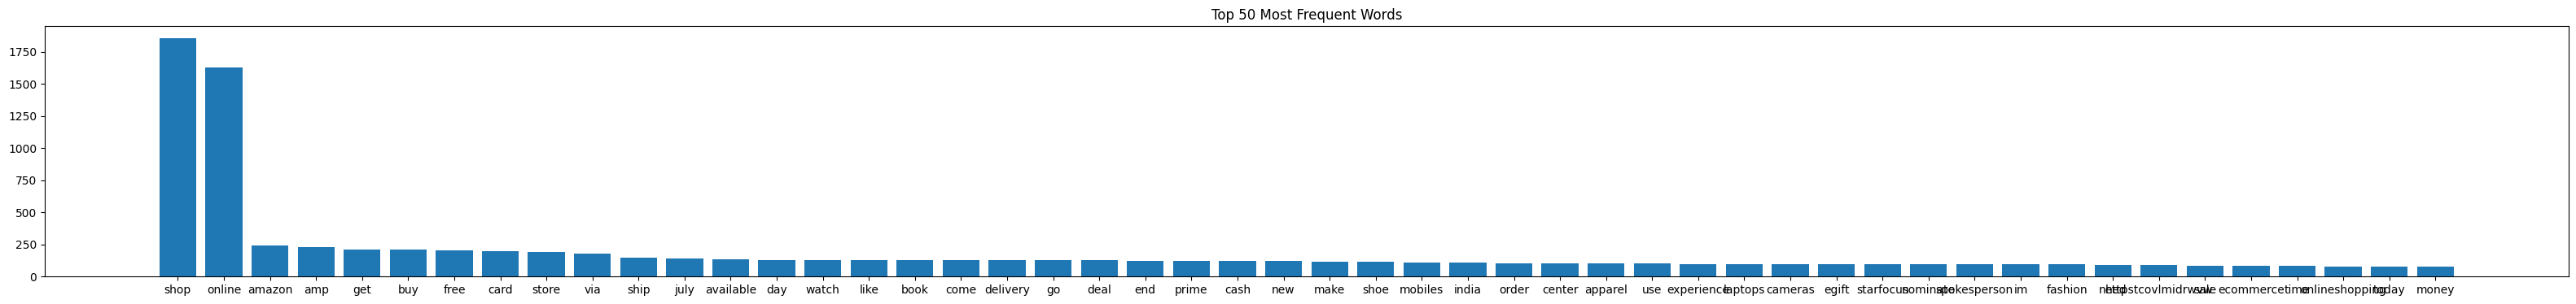

('shop', 'online', 'amazon', 'amp', 'get', 'buy', 'free', 'card', 'store', 'via', 'ship', 'july', 'available', 'day', 'watch', 'like', 'book', 'come', 'delivery', 'go', 'deal', 'end', 'prime', 'cash', 'new', 'make', 'shoe', 'mobiles', 'india', 'order', 'center', 'apparel', 'use', 'experience', 'laptops', 'cameras', 'egift', 'starfocus', 'nominate', 'spokesperson', 'im', 'fashion', 'need', 'httpstcovlmidrwvw', 'sale', 'ecommerce', 'time', 'onlineshopping', 'today', 'money')

TF-IDF Analysis on the same sample of the dataset:


<Figure size 5000x800 with 0 Axes>

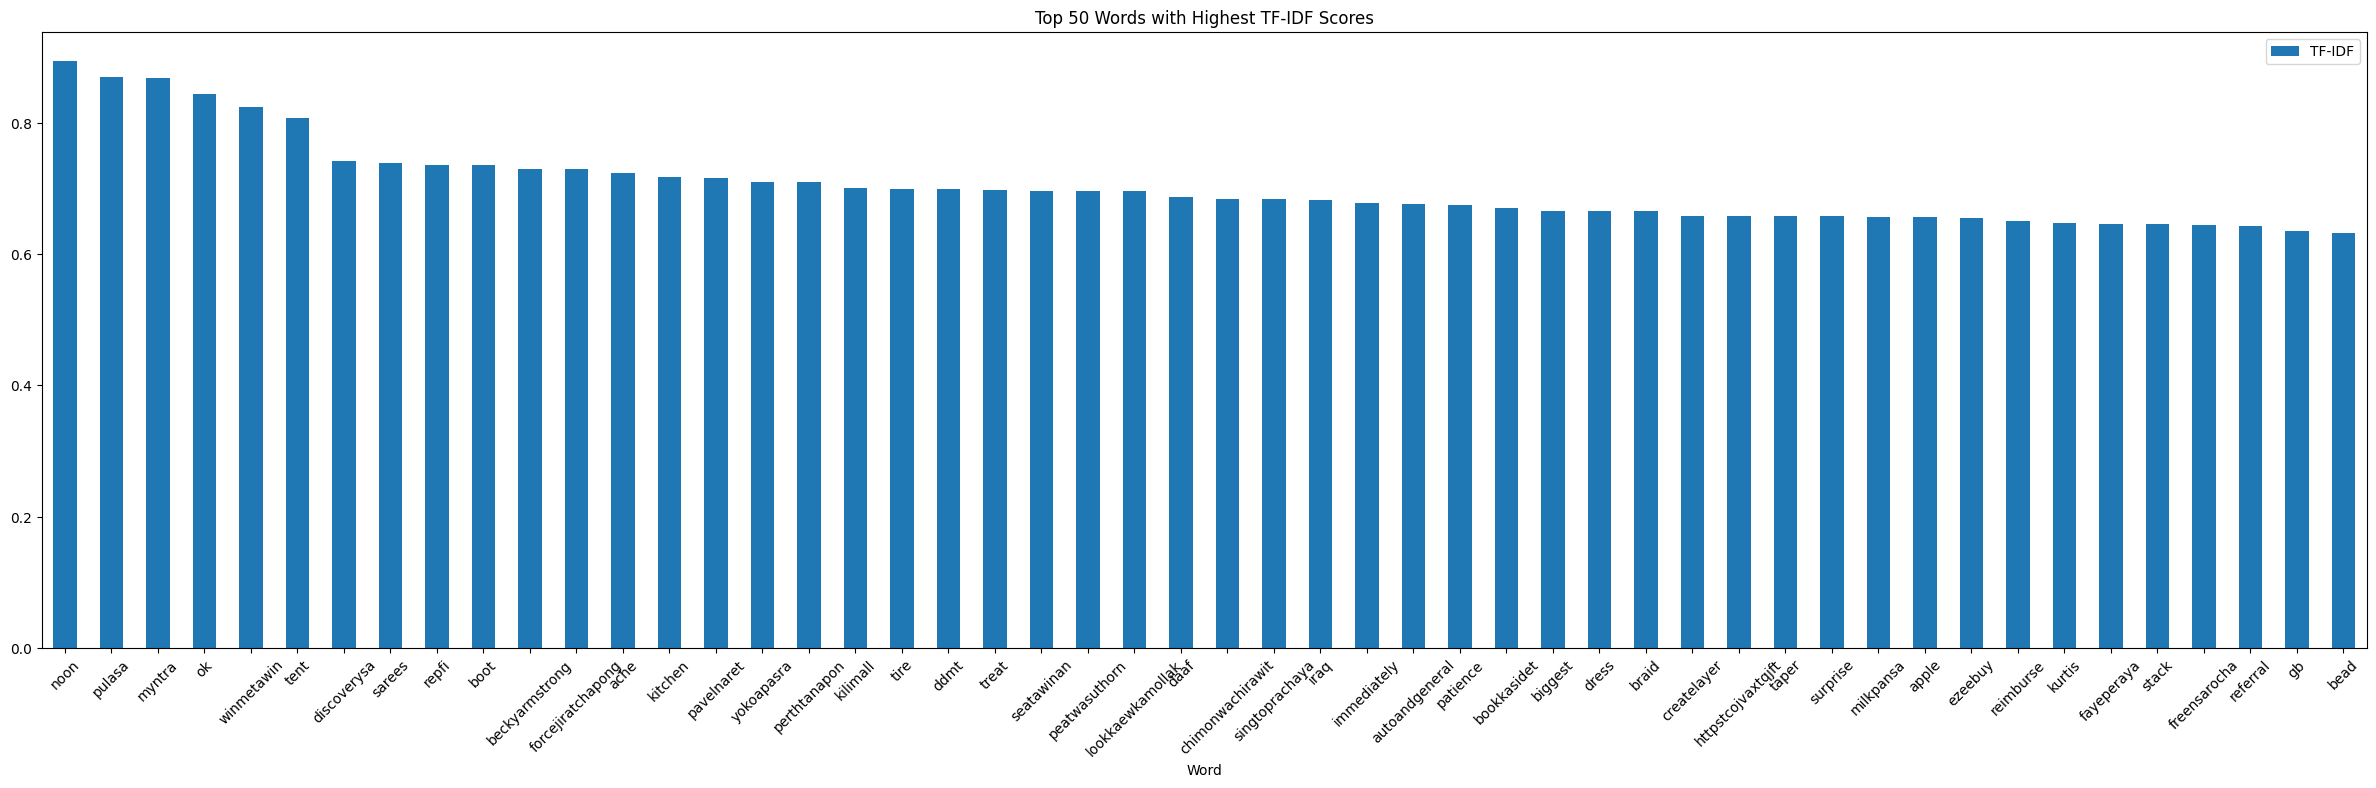

['noon' 'pulasa' 'myntra' 'ok' 'winmetawin' 'tent' 'discoverysa' 'sarees'
 'repfi' 'boot' 'beckyarmstrong' 'forcejiratchapong' 'ache' 'kitchen'
 'pavelnaret' 'yokoapasra' 'perthtanapon' 'kilimall' 'tire' 'ddmt' 'treat'
 'seatawinan' 'peatwasuthorn' 'lookkaewkamollak' 'daaf' 'chimonwachirawit'
 'singtoprachaya' 'iraq' 'immediately' 'autoandgeneral' 'patience'
 'bookkasidet' 'biggest' 'dress' 'braid' 'createlayer' 'httpstcojvaxtqjft'
 'taper' 'surprise' 'milkpansa' 'apple' 'ezeebuy' 'reimburse' 'kurtis'
 'fayeperaya' 'stack' 'freensarocha' 'referral' 'gb' 'bead']


In [ ]:
# Bag of Words Analysis
def bag_of_words_analysis(texts):
    """
    This function performs Bag of Words analysis and plots the top 10 frequent words.
    """
    word_counts = Counter()
    for text in texts:
        word_counts.update(text.split())

    most_common = word_counts.most_common(50)
    words, counts = zip(*most_common)

    # Plotting
    plt.figure(figsize=(40,4))
    plt.bar(words, counts)
    plt.title("Top 50 Most Frequent Words")
    plt.show()
    print(words)
    return most_common

from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# TF-IDF Analysis
def tf_idf_analysis(texts):
    """
    This function performs TF-IDF analysis and plots the top 10 words with highest TF-IDF scores.
    """
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = np.array(vectorizer.get_feature_names_out())

    # Gets the maximum TF-IDF score per word across all documents
    # Take the maximum value by column
    max_tfidf_scores = tfidf_matrix.max(axis=0).toarray().flatten()
    sorted_indices = np.argsort(max_tfidf_scores)[::-1]

    # Extract the top 10 words with high scores and their scores
    top_n_indices = sorted_indices[:50]
    top_n_words = feature_names[top_n_indices]
    top_n_scores = max_tfidf_scores[top_n_indices]

    # plot
    plt.figure(figsize=(50,8))
    df = pd.DataFrame({'Word': top_n_words, 'TF-IDF': top_n_scores})
    df.plot.bar(x='Word', y='TF-IDF', rot=45, title="Top 50 Words with Highest TF-IDF Scores",figsize=(30, 8))
    plt.show()
    print(top_n_words)
    return top_n_words

print("Bag of Words Analysis on a sample of the dataset:")
bow_results = bag_of_words_analysis(text_df['Text'])

# Perform TF-IDF Analysis on the same sample
print("\nTF-IDF Analysis on the same sample of the dataset:")
tfidf_results = tf_idf_analysis(text_df['Text'])


In [ ]:
# Load pre-trained model and tokenizer
model_name = 'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name)

def sentiment_score(review_text):
    # Encode the text
    encoded_review = tokenizer.encode_plus(
        review_text,
        max_length=512,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    # Forward pass, get logits
    input_ids = encoded_review['input_ids'].to('cpu')
    attention_mask = encoded_review['attention_mask'].to('cpu')

    with torch.no_grad():
        output = model(input_ids, attention_mask)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)

    return scores
text_df['sentiment_scores'] = text_df['Text'].apply(sentiment_score)

text_df[['negative', 'neutral', 'positive']] = pd.DataFrame(text_df['sentiment_scores'].tolist(), index=text_df.index)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


,count
sentiment,
neutral,1105
positive,382
negative,159


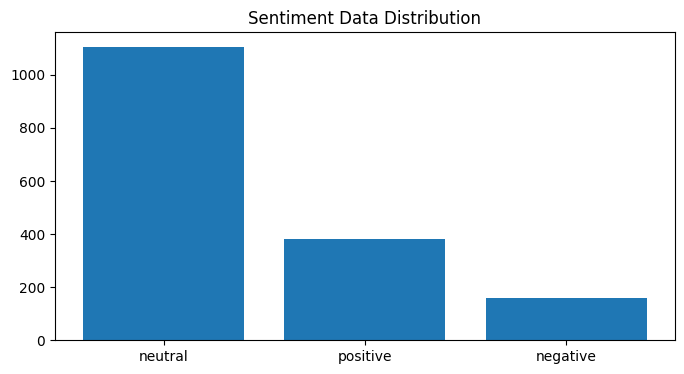

In [ ]:
# word cloud
# text_df = pd.read_excel('text.xlsx')
text_df['sentiment'] = text_df[['negative', 'neutral', 'positive']].idxmax(axis=1)
text_df.to_excel('text.xlsx', index=False)
val_count = text_df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")
val_count

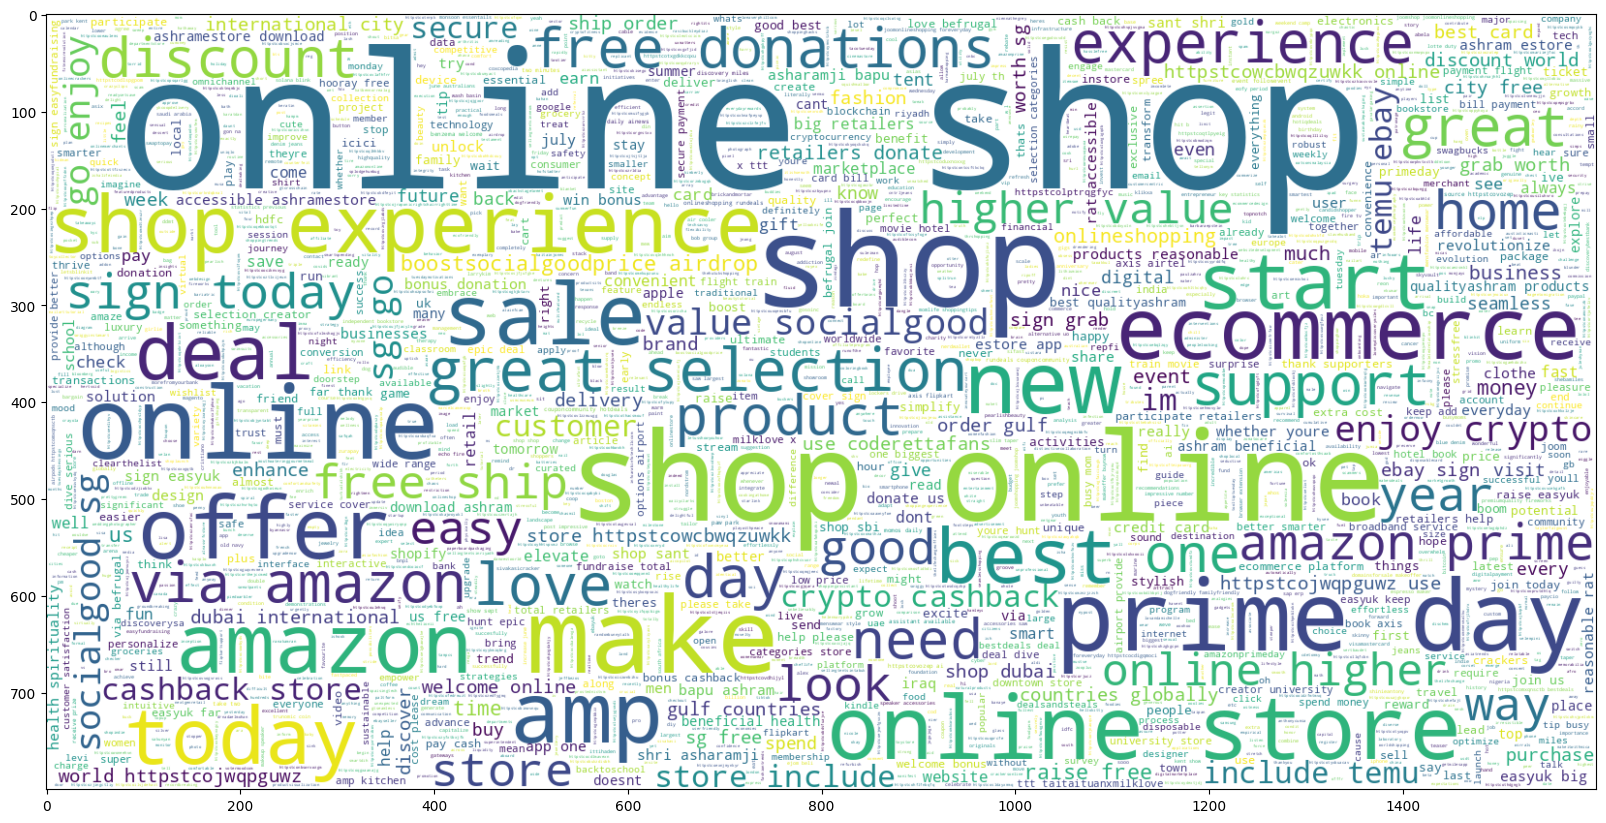

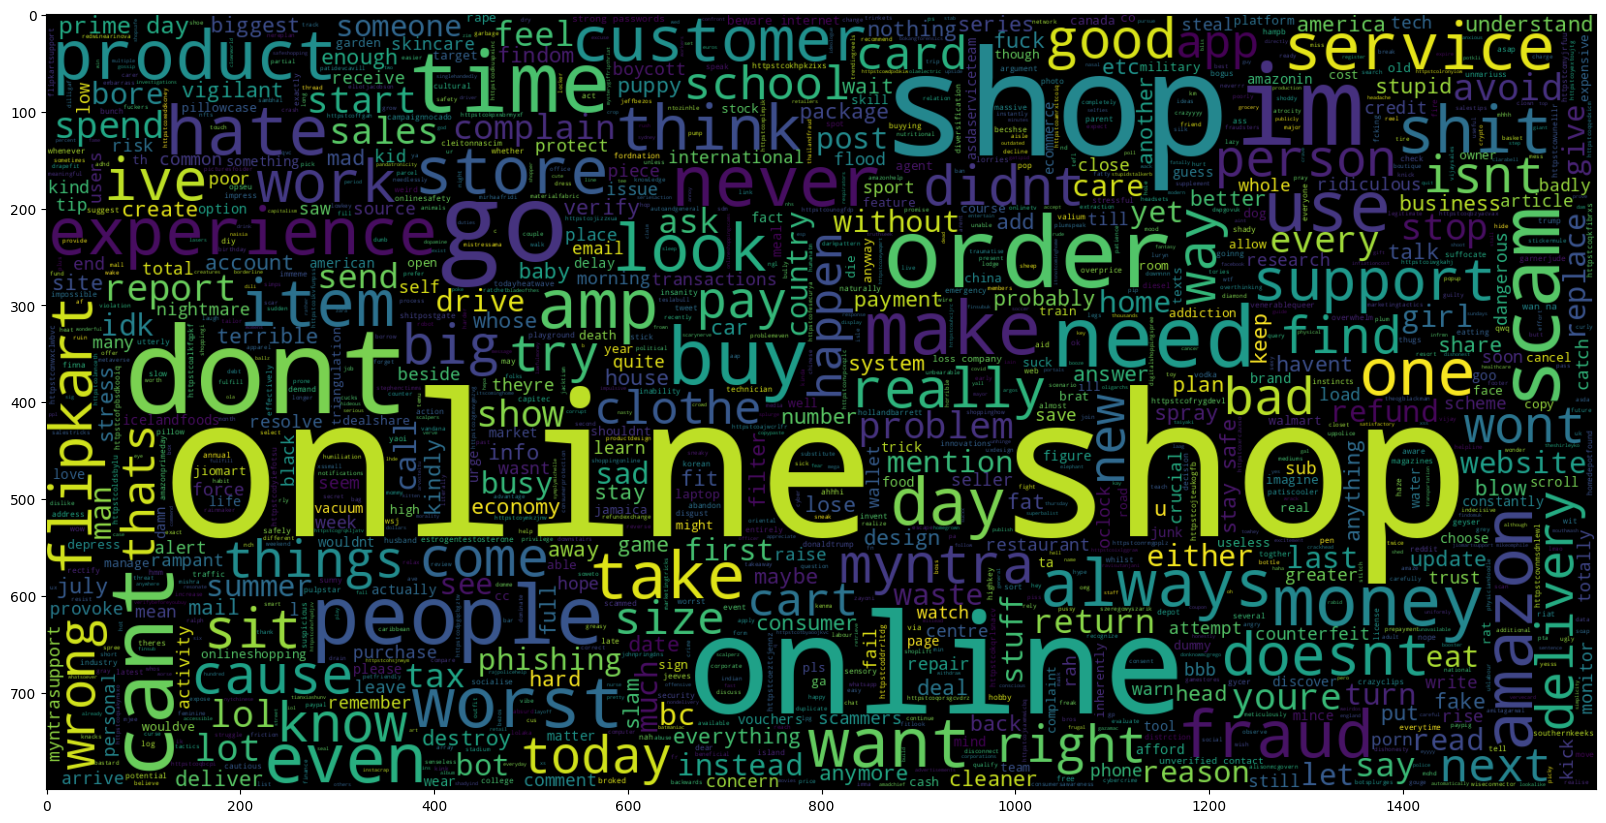

In [ ]:
# word cloud
plt.figure(figsize = (20,20))
wc = WordCloud(background_color = 'white',max_words = 2000 , width = 1600 , height = 800).generate(" ".join(text_df[text_df.sentiment == 'positive'].Text))
plt.imshow(wc , interpolation = 'bilinear')
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(text_df[text_df.sentiment == 'negative'].Text))
plt.imshow(wc , interpolation = 'bilinear')

In [ ]:
# LDA topic model
text_copy = text_df.copy(deep=False)
stop_words = set(['the','a'])
def generate_tokens(tweet):
    words=[]
    for word in tweet.split(' '):
    # using the if condition because we introduced extra spaces during text cleaning
        if word != '' and word not in stop_words:
        # if word!='':
           words.append(word)
    return words
text_copy['tokens']=text_copy.Text.apply(generate_tokens)
def create_dictionary(words):
    return corpora.Dictionary(words)
id2word=create_dictionary(text_copy['tokens'])

def create_document_matrix(tokens,id2word):
    corpus = []
    for text in tokens:
        corpus.append(id2word.doc2bow(text))
    return corpus
#passing the dataframe column having tokens and dictionary
corpus=create_document_matrix(text_copy['tokens'],id2word)
pyLDAvis.enable_notebook()
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=10, random_state=100, )
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.115495  0.069747       1        1  26.800877
3      0.063965  0.132193       2        1  19.245086
0     -0.136773  0.018036       3        1  13.479374
6     -0.124407  0.197623       4        1  11.260190
7      0.059123 -0.140778       5        1   7.347553
4     -0.058603  0.028225       6        1   7.287481
5     -0.028775 -0.078154       7        1   6.158134
8     -0.090223 -0.125011       8        1   3.556432
2      0.060472 -0.024440       9        1   2.567522
9      0.139726 -0.077441      10        1   2.297350, topic_info=          Term        Freq       Total Category  logprob  loglift
2207   cameras   83.000000   83.000000  Default  30.0000  30.0000
2205   apparel   86.000000   86.000000  Default  29.0000  29.0000
2208     egift   83.000000   83.000000  Default  28.0000  28.0000
225      watch  108.000000  108.000000  Default  27.0000  27.0000
2213   laptops   83.000000   83.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
829       book    1.709480  106.573839  Topic10  -6.0614  -0.3592
464       good    1.350108   33.417211  Topic10  -6.2974   0.5645
47          go    1.366010  103.704973  Topic10  -6.2857  -0.5562
958   whatsapp    1.272454   12.685719  Topic10  -6.3567   1.4739
836       read    1.284095   19.557366  Topic10  -6.3476   1.0501

[758 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
3322      1  0.198107   aarohi
3322      2  0.198107   aarohi
3322      3  0.198107   aarohi
3322     10  0.198107   aarohi
6924      5  0.637320   abroad
...     ...       ...      ...
1548      9  0.074406        x
1192      1  0.094518  youtube
1192      3  0.661625  youtube
1192      4  0.094518  youtube
1192      6  0.094518  youtube

[1745 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 7, 8, 5, 6, 9, 3, 10])